### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 24th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [17]:
import scipy.stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

In [251]:
data1 = np.load('../../homeworks/hw_data/hw4_data_1.npy')

# From Lecture 5 notes:

# sample mean for heteroscedastic uncertainties must be weighted with the sigmas
data1_mean = np.sum(data1[:,0] / (data1[:,1]**2)) / np.sum(1/(data1[:,1]**2))

# standard error on the sample mean
data1_sterr = np.sum(1/(data1[:,1]**2))**(-1/2)

print('Sample mean:',data1_mean)
print('St error on sample mean:', data1_sterr)

Sample mean: 4.942118214425304
St error on sample mean: 0.43024334605205083


2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.


In [252]:
# From my HW3:
def ln_likelihood(data,testMu,const=0):
    # function to get the ln likelihood of values for heteroscedastic gaussian data
    xvals = data[:,0]
    sigmavals = data[:,1]
    frac = np.sum(((xvals-testMu)**2)/(2*(sigmavals**2)))
    lnlike = const - frac
    return lnlike

# Sofi taught me the following:
    # lambda function: allows for one of your parameters to be unknown
    # beta (can call param anything) is the unknown thing
    # then when I pass func through optimizer it will vary testMu for me

func = lambda beta: -ln_likelihood(data=data1,testMu=beta)

# Find best fit mu using scipy.optimize
bestMu = scipy.optimize.fmin(func,3) # fmin needs an initial guess
print('Best mu',bestMu)

Optimization terminated successfully.
         Current function value: 2.807251
         Iterations: 17
         Function evaluations: 34
Best mu [4.94208984]


3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!


From Lecture 8, we have that Bayes' Rule is:

$$p(M\,|\,D) = \frac{p(D\,|\,M)\,p(M)}{p(D)},$$

where $D$ is for data and $M$ is for model. In words, this means

$${\rm Posterior \,\, Probability} = \frac{{\rm Likelihood}\times{\rm Prior}}{{\rm Evidence}}.$$

The likelihood for a heteroscedastic gaussian is

$$L = p(\{x_i\}|\mu,I) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}
{2\sigma_i^2}\right).$$

Then we multiply this by the uniform prior.

To get the evidence, we have to integrate the likelihood * the prior and set it equal to 1.

$$\int_{i}^{N}{\rm Posterior \,\, PDF \,} d\mu = \int_{i}^{N} \frac{{\rm Likelihood}\times{\rm Prior}}{{\rm Evidence \,}} d\mu = 1.$$

The evidence is just a constant, so

$$ {\rm Evidence} = \int_{i}^{N} {\rm Likelihood} \times {\rm Prior \,} d\mu .$$

Which becomes a sum, since we have a discrete amount of mu values:

$$ {\rm Evidence} = \sum_{i}^{N} {\rm Likelihood} \times {\rm Prior \,} \Delta \mu .$$


Since the normalization depends on $\Delta \mu$, this means it will change depending on the range of mu values we allow with np.linspace. In order to make the multiple posteriors we will create in this problem comparable in part 7, I'm choosing one muGrid that ranges from (0,10) with 1000 values, then the different priors will encompass the mu values which are "allowed," and I will also xlim certain plots in order to best see results of different priors.

Posterior probability density of the sample mean voltage: 2.681492837241116e-08
Un-normalized integral of posterior pdf: 2.8889798265065343e-06
Normalized integral of posterior pdf: 1.0


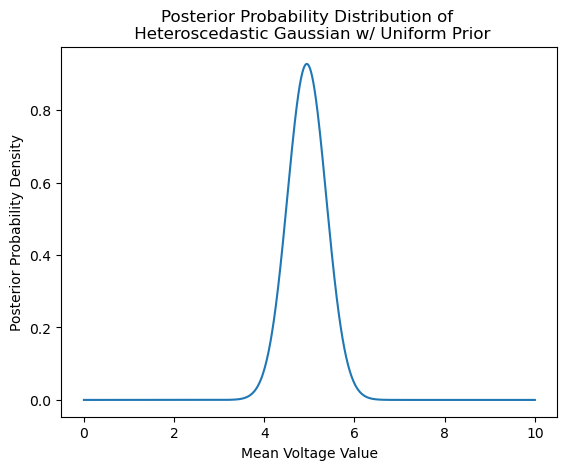

In [375]:
unif = scipy.stats.uniform(3,4) # [loc,scale] !! not [lower,upper]

def likelihood(data,testMu,const=0):
    # returns likelihood value for a single test mu 

    # like = np.exp(ln_likelihood(data,testMu,const))
        # Hypothetically this could work, but don't want to take any chances
    
    factor = 1/(data[:,1]*np.sqrt(2*np.pi))
    num = -(data[:,0]-testMu)**2
    denom = 2*data[:,1]**2

    like = np.prod(factor * np.exp(num/denom))
    
    return like

# get posterior probability for the mean voltage
postProbMean = likelihood(data1,data1_mean) * unif.pdf(data1_mean)
print('Posterior probability density of the sample mean voltage:',postProbMean)

# plot posterior probability across voltages
muGrid = np.linspace(0,10,1000)
postProbs = np.empty((len(muGrid),1))

# get unnormalized posterior (likelihood * prior)
for i in range(len(muGrid)): # looping instead of trying to pass muGrid through likelihood()
    posterior = likelihood(data1,muGrid[i]) * unif.pdf(muGrid[i])
    postProbs[i] = posterior

print('Un-normalized integral of posterior pdf:', np.sum(postProbs)) 

# normalizing is dividing by the evidence
deltaMu = muGrid[1]-muGrid[0]
evidence = np.sum(postProbs)*deltaMu
postProbs = postProbs / evidence

# Check that the sum of the pdf is 1
print('Normalized integral of posterior pdf:',np.sum(postProbs*deltaMu))

plt.plot(muGrid,postProbs);
plt.title('Posterior Probability Distribution of \n Heteroscedastic Gaussian w/ Uniform Prior');
plt.xlabel('Mean Voltage Value');
plt.ylabel('Posterior Probability Density');


4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

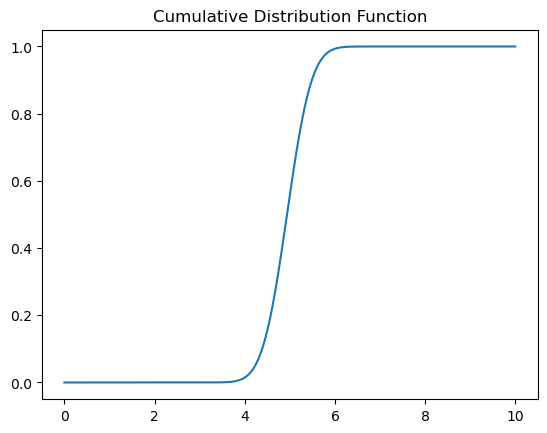

In [374]:
# Create a cdf using cumsum, which when called[i] returns the cumulative sum of the elements up to element i
postCDF = np.cumsum(postProbs*deltaMu)
plt.plot(muGrid,postCDF);
plt.title('Cumulative Distribution Function');


In [341]:
# To get an equal tailed credible region we want to find the mu values that give us (1-0.683)/2 of the cdf on each end
lowerPercent = (1-0.683)/2
upperPercent = 1-(1-0.683)/2
print(lowerPercent,upperPercent)

# Recover mu values that result in these percentages 
    # If we had a scipy object, we'd do this from ppf (inverse of CDF)
    # Can't use np.percentile because it treats histograms
    # Need to use indexing

lowerMu_idx = np.where(postCDF<=lowerPercent) # last of these vals will be the lowerMu bound index
lowerMu_idx = lowerMu_idx[-1][-1]

upperMu_idx = np.where(postCDF>=upperPercent) # first of these vals will be the upperMu bound index
upperMu_idx = upperMu_idx[0][0]

credMuLow = muGrid[lowerMu_idx]
credMuHigh = muGrid[upperMu_idx]

print('Credible region:',credMuLow,credMuHigh)

0.15849999999999997 0.8415
Credible region: 4.504504504504505 5.375375375375375


The equal-tailed credible region is then (4.45,5.38) which encompasses 68.3% of the posterior distribution.

We can plot the posterior now with the credible region indicated as well as the sample mean +/- standard error and the MAP to compare them.

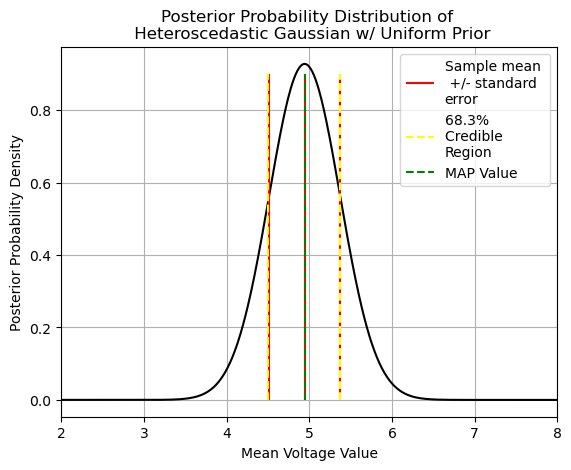

In [381]:
# posterior pdf
plt.plot(muGrid,postProbs,color='black');

# sample mean +/- standard error of the mean
plt.vlines(data1_mean-data1_sterr,ymin=0,ymax=0.9,color='red',label='Sample mean \n +/- standard \nerror')
plt.vlines(data1_mean,ymin=0,ymax=0.9,color='red')
plt.vlines(data1_mean+data1_sterr,ymin=0,ymax=0.9,color='red')

# credible region
plt.vlines(credMuLow,ymin=0,ymax=0.9,color='yellow',linestyle='--',label='68.3% \nCredible \nRegion')
plt.vlines(credMuHigh,ymin=0,ymax=0.9,color='yellow',linestyle='--')

# MAP value
mapMax = postProbs.max()
mapIdx = np.where(postProbs==mapMax)
mapVal = muGrid[mapIdx[0]]
plt.vlines(mapVal,ymin=0,ymax=0.9,color='green',linestyle='--',label='MAP Value')

plt.title('Posterior Probability Distribution of \n Heteroscedastic Gaussian w/ Uniform Prior');
plt.legend(loc='upper right');
plt.grid();
plt.xlim(2,8)
plt.xlabel('Mean Voltage Value');
plt.ylabel('Posterior Probability Density');

In [343]:
print(mapVal,data1_mean) # To check how close these values are

[4.94494494] 4.942118214425304


It appears that the MAP value and the credible region boundaries correspond pretty well to the sample mean +/- the standard error. This was not as true, however, when I initialized muGrid with fewer values (I tested 50, then 100, now 1000). Since the numerical integral is the most accurate with many slices, I believe the most accurate comparison between credible region and sample mean +/- standard error is for them to be close to equal, at least for this specific prior distribution. 

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 


Posterior probability density of the sample mean voltage: 1.340746418620558e-07
Un-normalized integral of posterior pdf: 9.297140800183469e-06
Normalied integral of posterior: 1.0


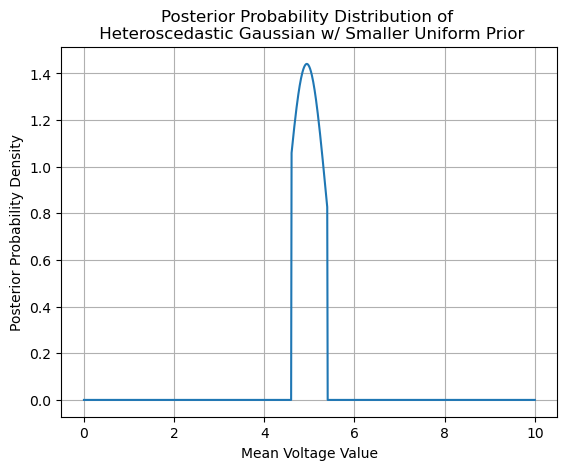

In [382]:
unif2 = scipy.stats.uniform(4.6,0.8) 

# get posterior probability for the mean voltage
postProbMean2 = likelihood(data1,data1_mean) * unif2.pdf(data1_mean)
print('Posterior probability density of the sample mean voltage:',postProbMean2)

# plot posterior probability across voltages
    # keep muGrid the same for comparison purposes later
postProbs2 = np.empty((len(muGrid),1))

for i in range(len(muGrid)): # looping instead of trying to pass muGrid through likelihood()
    posterior2 = likelihood(data1,muGrid[i]) * unif2.pdf(muGrid[i])
    postProbs2[i] = posterior2

print('Un-normalized integral of posterior pdf:', np.sum(postProbs2)) 

# normalizing is dividing by the evidence
evidence2 = np.sum(postProbs2)*deltaMu
postProbs2 = postProbs2 / evidence2
# check normalization
print('Normalied integral of posterior:',np.sum(postProbs2*deltaMu))

plt.plot(muGrid,postProbs2);
plt.title('Posterior Probability Distribution of \n Heteroscedastic Gaussian w/ Smaller Uniform Prior');
plt.xlabel('Mean Voltage Value');
plt.grid();
plt.ylabel('Posterior Probability Density');


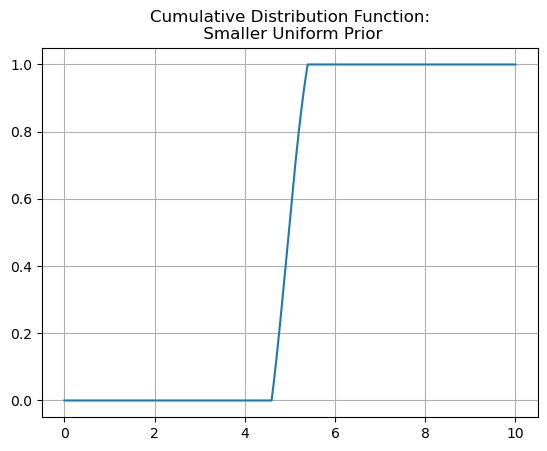

In [383]:
postCDF2 = np.cumsum(postProbs2*deltaMu)
plt.plot(muGrid,postCDF2);
plt.grid();
plt.title('Cumulative Distribution Function:\n Smaller Uniform Prior');


In [384]:
lowerMu_idx2 = np.where(postCDF2<=lowerPercent) # last of these vals will be the lowerMu bound index
lowerMu_idx2 = lowerMu_idx2[-1][-1]

upperMu_idx2 = np.where(postCDF2>=upperPercent) # first of these vals will be the upperMu bound index
upperMu_idx2 = upperMu_idx2[0][0]

credMuLow2 = muGrid[lowerMu_idx2]
credMuHigh2 = muGrid[upperMu_idx2]

print('Credible region:',credMuLow2,credMuHigh2)

Credible region: 4.724724724724725 5.235235235235235


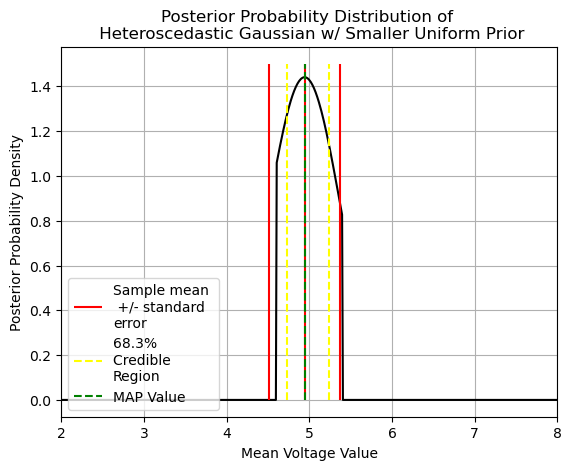

In [387]:
# posterior pdf
plt.plot(muGrid,postProbs2,color='black');

# sample mean +/- standard error of the mean
plt.vlines(data1_mean-data1_sterr,ymin=0,ymax=1.5,color='red',label='Sample mean \n +/- standard \nerror')
plt.vlines(data1_mean,ymin=0,ymax=1.5,color='red')
plt.vlines(data1_mean+data1_sterr,ymin=0,ymax=1.5,color='red')

# credible region
plt.vlines(credMuLow2,ymin=0,ymax=1.5,color='yellow',linestyle='--',label='68.3% \nCredible \nRegion')
plt.vlines(credMuHigh2,ymin=0,ymax=1.5,color='yellow',linestyle='--')

# MAP value
mapMax2 = postProbs2.max()
mapIdx2 = np.where(postProbs2==mapMax2)
mapVal2 = muGrid[mapIdx2[0]]
plt.vlines(mapVal2,ymin=0,ymax=1.5,color='green',linestyle='--',label='MAP Value')

plt.title('Posterior Probability Distribution of \n Heteroscedastic Gaussian w/ Smaller Uniform Prior');
plt.legend(loc='lower left');
plt.grid();
plt.xlim(2,8)
plt.xlabel('Mean Voltage Value');
plt.ylabel('Posterior Probability Density');

So far, it's making sense that the credible region should get narrower as the prior gets more restrictive. This means it falls inside the sample mean +/- standard error range, which doesn't rely on priors. In fact, our standard error extends beyond the boundaries of the prior, so whether or not the prior being restrictive is a good thing, we know it's no longer comparable to the standard error region. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.


Posterior probability density of the sample mean voltage: 2.845028816099295e-10
Un-normalized integral of posterior pdf: 1.1498284222881925e-06
Normalized integral of posterior PDF: 1.0000000000000002


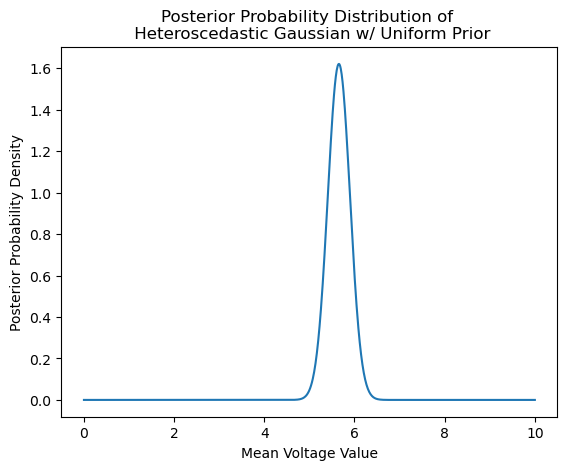

In [391]:
gaussPrior = scipy.stats.norm(6,0.3)

# get posterior probability for the mean voltage
postProbMean3 = likelihood(data1,data1_mean) * gaussPrior.pdf(data1_mean)
print('Posterior probability density of the sample mean voltage:',postProbMean3)

# plot posterior probability across voltages
postProbs3 = np.empty((len(muGrid),1))

for i in range(len(muGrid)): # looping instead of trying to pass muGrid through likelihood()
    posterior3 = likelihood(data1,muGrid[i]) * gaussPrior.pdf(muGrid[i])
    postProbs3[i] = posterior3

print('Un-normalized integral of posterior pdf:', np.sum(postProbs3)) 

# normalizing is dividing by the evidence
evidence3 = np.sum(postProbs3)*deltaMu
postProbs3 = postProbs3 / evidence3
# check normalization
print('Normalized integral of posterior PDF:',np.sum(postProbs3*deltaMu))


plt.plot(muGrid,postProbs3);
plt.title('Posterior Probability Distribution of \n Heteroscedastic Gaussian w/ Uniform Prior');
plt.xlabel('Mean Voltage Value');
plt.ylabel('Posterior Probability Density');


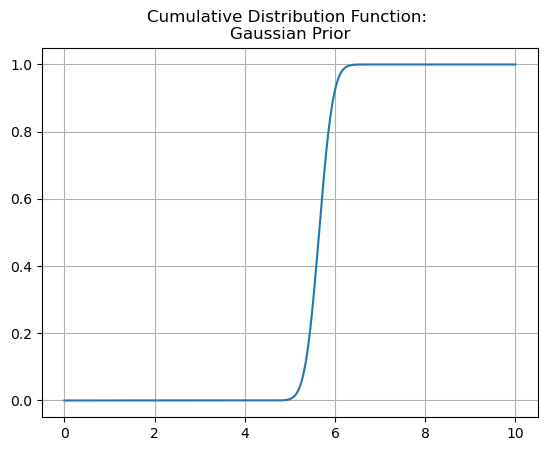

In [392]:
postCDF3 = np.cumsum(postProbs3*deltaMu)
plt.plot(muGrid,postCDF3);
plt.grid();
plt.title('Cumulative Distribution Function: \nGaussian Prior');


In [393]:
lowerMu_idx3 = np.where(postCDF3<=lowerPercent) # last of these vals will be the lowerMu bound index
lowerMu_idx3 = lowerMu_idx3[-1][-1]

upperMu_idx3 = np.where(postCDF3>=upperPercent) # first of these vals will be the upperMu bound index
upperMu_idx3 = upperMu_idx3[0][0]

credMuLow3 = muGrid[lowerMu_idx3]
credMuHigh3 = muGrid[upperMu_idx3]

print('Credible region:',credMuLow3,credMuHigh3)

Credible region: 5.395395395395395 5.895895895895896


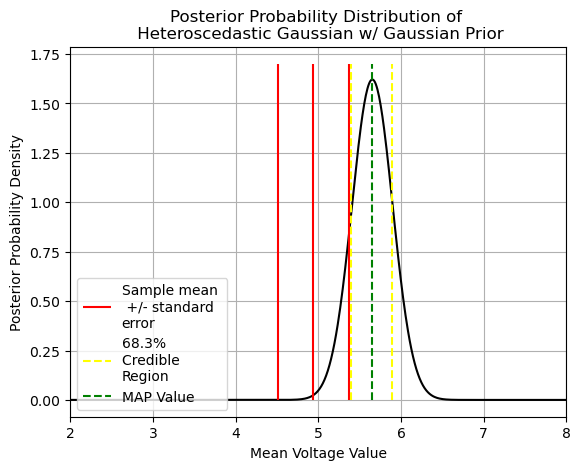

In [395]:
# posterior pdf
plt.plot(muGrid,postProbs3,color='black');

# sample mean +/- standard error of the mean
plt.vlines(data1_mean-data1_sterr,ymin=0,ymax=1.7,color='red',label='Sample mean \n +/- standard \nerror')
plt.vlines(data1_mean,ymin=0,ymax=1.7,color='red')
plt.vlines(data1_mean+data1_sterr,ymin=0,ymax=1.7,color='red')

# credible region
plt.vlines(credMuLow3,ymin=0,ymax=1.7,color='yellow',linestyle='--',label='68.3% \nCredible \nRegion')
plt.vlines(credMuHigh3,ymin=0,ymax=1.7,color='yellow',linestyle='--')

# MAP value
mapMax3 = postProbs3.max()
mapIdx3 = np.where(postProbs3==mapMax3)
mapVal3 = muGrid[mapIdx3[0]]
plt.vlines(mapVal3,ymin=0,ymax=1.7,color='green',linestyle='--',label='MAP Value')

plt.title('Posterior Probability Distribution of \n Heteroscedastic Gaussian w/ Gaussian Prior');
plt.legend(loc='lower left');
plt.grid();
plt.xlim(2,8)
plt.xlabel('Mean Voltage Value');
plt.ylabel('Posterior Probability Density');

Even bigger of a difference between the credible region, which is informed by the priors, and the standard error region, which is not. I almost wonder if the Bayesian confidence interval is too informed by the priors, but I suppose the remedy for that is to not limit ourselves to incredibly restrictive priors and/or compare with sample means and standard errors when necessary.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.


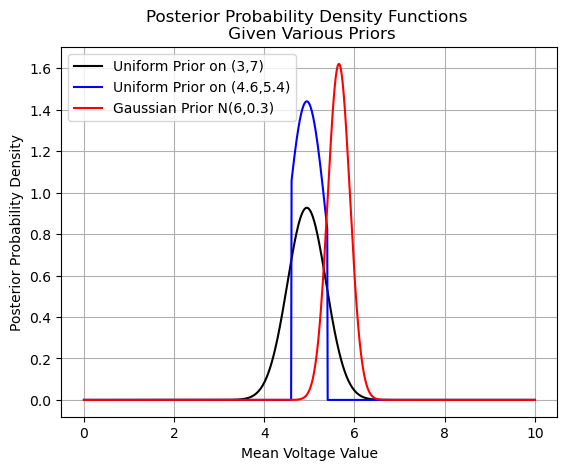

In [396]:
plt.plot(muGrid,postProbs,color='black',label='Uniform Prior on (3,7)');
plt.plot(muGrid,postProbs2,color='blue',label='Uniform Prior on (4.6,5.4)');
plt.plot(muGrid,postProbs3,color='red',label='Gaussian Prior N(6,0.3)');

plt.grid();
plt.legend();
plt.title('Posterior Probability Density Functions \n Given Various Priors');
plt.ylabel('Posterior Probability Density');
plt.xlabel('Mean Voltage Value');


8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

Since 

$${\rm Posterior \,\, Probability} = \frac{{\rm Likelihood}\times{\rm Prior}}{{\rm Evidence}},$$

and our delta function prior can be thought of as a piecewise function where

$$ \delta (x-a) = \infty {\, \,\rm if \, \,} x = a $$

and 

$$ \delta (x-a) = 0 {\, \,\rm if \, \,} x \neq a. $$

Since we are multiplying the likelihood by the prior, and at every point except $a$ this numerator becomes 0, the only nonzero point occurs when $x=a$. This is essentially evaluating the likelihood only at $x=a$. Delta functions also have the property that they are normalized to 1, so we don't have to worry about multiplying by infinity when we evaluate the likelihood at the point we care about. We should still make sure the posterior is normalized though.

In [454]:
postDelta = likelihood(data=data1,testMu=bestMu) # eval likelihood at bestMu found in (1)
print('Un-normalized integral of posterior PDF:',postDelta)

# we are limited by not having infinite mu values, so this is only approximately a delta function
evidenceDelta = postDelta*deltaMu 

# so the normalized posterior value would be
postDeltaNorm = postDelta/evidenceDelta

#check the normalization
print('Normalized integral of posterior PDF:',postDeltaNorm*deltaMu)

# compare to evidence from first uniform prior
print('Delta Prior Evidence:',evidenceDelta)
print('Wide Uniform Prior Evidence:',evidence)

Un-normalized integral of posterior PDF: 1.0725971325645043e-07
Normalized integral of posterior PDF: 1.0
Delta Prior Evidence: 1.0736708033678722e-09
Wide Uniform Prior Evidence: 2.891871698204739e-08


I am surprised that it is only one order of magnitude smaller than the evidence resulting from the Gaussian prior, I had expected it to be many orders of magnitude smaller. That being said, an order of magnitude is a big difference, which makes sense because a delta function is a very restrictive prior. 

In [455]:
bayes_deltaUnif = evidence/evidenceDelta
print('Bayes factor of Gauss/Wide Uniform:',bayes_deltaUnif)

Bayes factor of Gauss/Wide Uniform: 26.934435481840108


We'd consider this "strong" evidence that the model with the wide uniform prior does better than the delta function prior. I wouldn't consider an Occam's penalty being invoked because the mu values encompassed in the wide prior are still the variation of only one parameter. 

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [354]:
data2 = np.load('/home/rothj1/Desktop/AstroStats/repos/astr_8070_s24/coursework/homeworks/hw_data/hw4_data_2.npy')
x, y, sigma_y = data2

In [355]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

Enumerate needs to be passed an iterable, so theta needs to be a tuple with the size being the degree of the polynomial you want to fit, where the values of the tuple are the coefficients of the polynomial. So, for a linear model, we need theta to have a length of 2. 

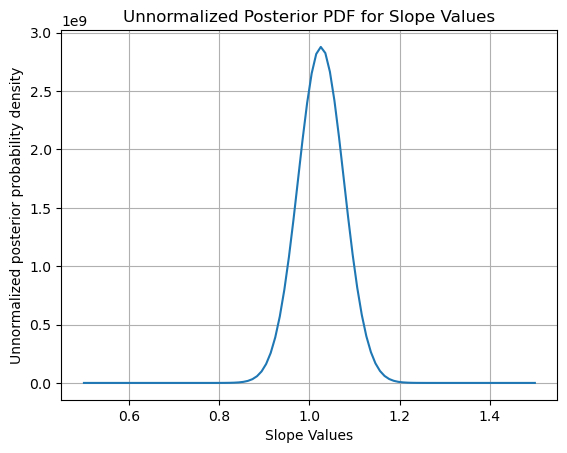

In [436]:
slopeGrid = np.linspace(0.5,1.5,100)

uniform = scipy.stats.uniform(0.5,1.0) 

def L(theta,data,model=polynomial_fit):
    likeli = np.exp(logL(theta,data,model))
    return likeli
    
posteriors = np.empty(len(slopeGrid))
likes_1d = np.empty(len(slopeGrid))

for i in range(len(slopeGrid)):

    theta = [-0.23,slopeGrid[i]]

    like = L(theta=theta,data=data2)
    likes_1d[i] = like
    
    pos = like * uniform.pdf(slopeGrid[i]) # keep y-int fixed
    posteriors[i] = pos

plt.plot(slopeGrid,posteriors);
plt.title('Unnormalized Posterior PDF for Slope Values');
plt.xlabel('Slope Values');
plt.ylabel('Unnormalized posterior probability density');
plt.grid();

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!


Evidence: 365684733.1606578
Evidence: 0.3656847331606578 billion
Normalized integral of posterior PDF: 1.0000000000000002


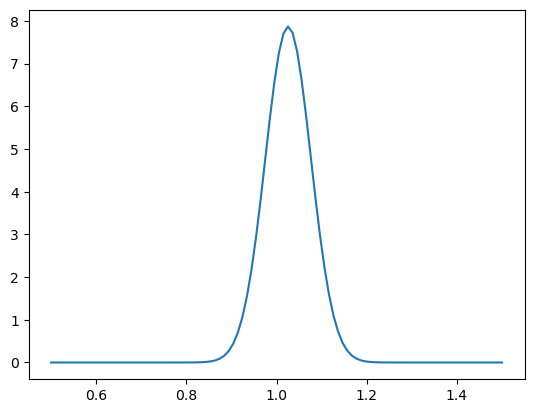

In [425]:
dSlope = slopeGrid[1]-slopeGrid[0]

evidence1d = np.sum(posteriors)*dSlope
print('Evidence:',evidence1d)
print('Evidence:',evidence1d/1e9,'billion')

# Plot normalized posterior PDF and check that the sum of the PDF is 1
post1d_norm = posteriors / evidence1d

plt.plot(slopeGrid,post1d_norm)
print('Normalized integral of posterior PDF:',np.sum(post1d_norm*dSlope))

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

In [434]:
quadGrid = np.linspace(-1,0.25,100)

linPrior = uniform # same prior as before
quadPrior = scipy.stats.uniform(-1,1.25) # width is 1.25 to end at 0.25

posteriors_2d = np.empty((len(slopeGrid),len(quadGrid))) # size of 100 rows, 100 cols
likes_2d = np.empty((len(slopeGrid),len(quadGrid)))

for i in range(len(slopeGrid)):
    for j in range(len(quadGrid)):

        theta = [-0.23,slopeGrid[i],quadGrid[j]] # keep y-int fixed
        
        like = L(theta=theta,data=data2)
        likes_2d[i][j] = like

        pos = like * linPrior.pdf(slopeGrid[i]) * quadPrior.pdf(quadGrid[j])
        posteriors_2d[i][j] = pos

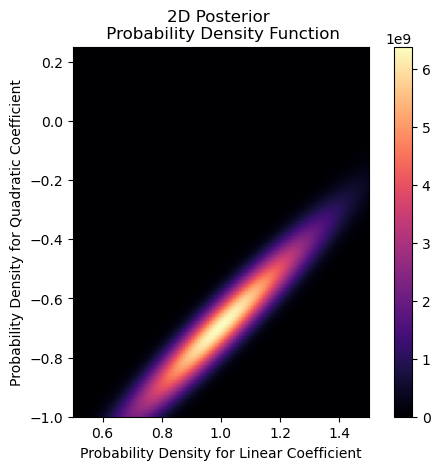

In [462]:
plt.imshow(posteriors_2d,cmap='magma',extent=[slopeGrid[0],slopeGrid[-1],quadGrid[0],quadGrid[-1]]);
plt.colorbar();
plt.title('2D Posterior \n Probability Density Function');
plt.xlabel('Probability Density for Linear Coefficient');
plt.ylabel('Probability Density for Quadratic Coefficient');

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

In [428]:
dQuad = quadGrid[1]-quadGrid[0]

evidence2d = np.sum(posteriors_2d)*dSlope*dQuad
print('2D Bayesian Evidence:',evidence2d)
print('2D Bayesian Evidence:',evidence2d/1e9,'billion')

# Check that this is the right normalization
post2d_norm = posteriors_2d / evidence2d
print('Normalized integral of 2d posteriors:',np.sum(post2d_norm*dSlope*dQuad))

2D Bayesian Evidence: 493061001.65705675
2D Bayesian Evidence: 0.49306100165705674 billion
Normalized integral of 2d posteriors: 1.0


6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

In [432]:
# The Bayes factor is the ratio of the evidence two models
# Do both just to see
bayesFactor_1over2 = evidence1d / evidence2d
print('Bayes Factor of Z1/Z2:',bayesFactor_1over2)

bayesFactor_2over1 = evidence2d / evidence1d
print('Bayes factor of Z2/Z1:',bayesFactor_2over1)

Bayes Factor of Z1/Z2: 0.7416622526050152
Bayes factor of Z2/Z1: 1.3483226313427696


For the quadratic model over the linear model, our bayes factor being 1.34 is considered "not worth more than a bare mention." We'd have to compare the models with other metrics, perhaps like the BIC, to make a conclusion. 

From Lecture 9, we have that for $N$ data points and a model with $k$ parameters,

$${\rm BIC} \equiv -2 \ln [L_0(M)] + k \ln N$$ 

where $L_0 (M)$ means maximum value of the likelihood.

In [442]:
# get maximum values of likelihood arrays from 1d and 2d cases
likeMax1d = np.max(likes_1d)
likeMax2d = np.max(likes_2d)

# get BIC values for each model
bic_1d = -2*np.log(likeMax1d) + 1*np.log(len(slopeGrid)) # N = 100
bic_2d = -2*np.log(likeMax2d) + 2*np.log(len(slopeGrid)*len(quadGrid)) # N = 1e4

print('BIC 1D:',bic_1d)
print('BIC 2D:',bic_2d)

BIC 1D: -38.95553992520727
BIC 2D: -27.179045185730892


A smaller BIC wins in a model comparison, so here we have that the linear model is better than the linear + quadratic model. We wouldn't say these results are conflicting with the previous Bayes Factor test because those were essentially inconclusive. Also, while I can't say that the reason the BIC favored the linear model is because of the Occam's razor penalty, it definitely plays a role (big or small) that the winning model has fewer parameters. 

The BIC comparison of models from Lecture 9 had the linear model with BIC = 17.31 and the quadratic model with BIC = 18.45. These are much more positive than our BIC values here, perhaps because of fewer data points (N=20) or because of more parameters (2 for linear, 3 for quadratic, though this shouldn't make such a large difference). The linear model still won against the quadratic model, but by a smaller margin (1.14) than our margin here (11.77). I would imagine this has to do with the N values being much more different from each other than in the lecture, where both models had N = 20, but I can't be exactly sure. 